# loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


# loading data 

In [3]:
data=pd.read_csv('/content/Ecommerce_data.csv',encoding='unicode_escape', header=0, dtype={'CustomerID': str},parse_dates=['InvoiceDate'],
                  infer_datetime_format=True)

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


# EDA

## frequently bought product

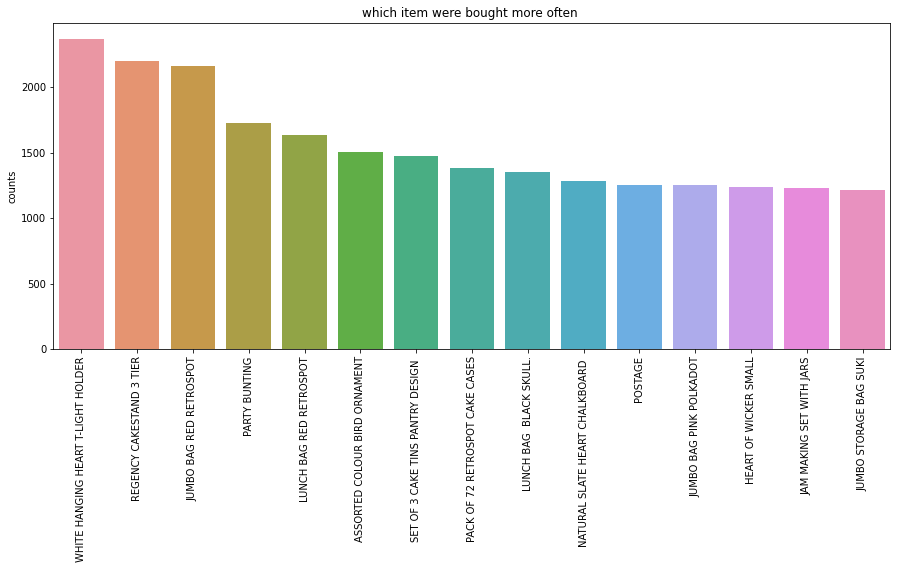

In [6]:
item_count= data['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(15,6))
sns.barplot(item_count.index , item_count.values)
plt.ylabel('counts')
plt.title('which item were bought more often ')
plt.xticks(rotation=90)
plt.show()

## world wide sale distribution

In [7]:
world_map = data[['CustomerID','InvoiceNo','Country']].groupby(['CustomerID','InvoiceNo','Country']).count().reset_index(drop=False)

In [8]:
countries= world_map['Country'].value_counts()

In [9]:
countries

United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
USA                         7
Iceland                     7
Israel                      6
Canada                      6
Greece                      6
Czech Republic              5
European Community          5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Bahrain   

In [10]:
import plotly.graph_objs as go 
from plotly.offline import iplot 
# defining the data to be plotted in the choropleth map 
dat = dict(type ='choropleth',
            locations= countries.index,#index of the countries dataframe 
            locationmode='country names',# location mode is country name 
            z= countries) # data to be plotted
layout=dict(title={'text':'number of order by  countries ',
                   'xanchor':'center', # title alingment 
                   'yanchor':'top'}, # title alingment 
            geo=dict(resolution=50,
                     showocean=True,
                     oceancolor='lightBlue',
                     landcolor='whitesmoke',
                     showframe=True),
            template='plotly_white', #background color (white)
            height=600,
            width=100)
choromap=go.Figure(data=[dat],layout=layout)
iplot(choromap,validate=False)

## quantative data analysis

In [11]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [12]:
data.shape

(541909, 8)

here min quantity is negaive because their must revalue also in the orders 


In [13]:
data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


## Data pre processing 


In [14]:
def replace_with_thresholds(dataframe,variable,q1=0.25,q3=0.75):
  df=dataframe.copy()
  quartile1=df[variable].quantile(q1)
  quartile3=df[variable].quantile(q3)
  iqr=quartile3-quartile1
  up_limit=quartile3+1.5*iqr
  low_limit=quartile1-1.5*iqr
  df=df[(df[variable]>=low_limit)& (df[variable]<=up_limit)]
  return df

In [15]:
def ecomerce_preprocess(dataframe):
  df=dataframe.copy()
  #missing values
  df=df.dropna()
  # cancelled order & quantity 
  df=df[~df['InvoiceNo'].str.contains('C',na=False)] # na is ignore the null values
  df=df[df['Quantity']>0]
  # replace outlier
  df=replace_with_thresholds(df,'Quantity')
  df=replace_with_thresholds(df,'UnitPrice')
  # total price
  df['Totalprice']=df['Quantity']*df['UnitPrice']
  return df
  

In [16]:
df=ecomerce_preprocess(data)

In [17]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Totalprice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [18]:
df.shape

(338182, 9)

#RFM Analysis

In [19]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [20]:
today_date= dt.datetime(2011,12,11)
print(today_date)

2011-12-11 00:00:00


In [21]:
rfm= df.groupby('CustomerID').agg({
    # calculate the number of days since the customer most recent trancsaction (recency)
    'InvoiceDate': lambda x:(today_date - x.max()).days,
    # frequency 
    'InvoiceNo':lambda x:x.nunique(),
    #calculte the each amount invest by each customer (monetry)
    'Totalprice': lambda x :x.sum()
})

rfm.columns= ['recency','frequency','monetry']
rfm=rfm[rfm['monetry']>=0]
# reset the index of dataframe
rfm=rfm.reset_index()

In [22]:
rfm['frequency']

0        7
1        3
2        1
3        1
4        7
        ..
4187     1
4188     1
4189     2
4190    16
4191     3
Name: frequency, Length: 4192, dtype: int64

## rfm score


In [23]:
def get_rfm_score(dataframe):
  df=dataframe.copy()
  df['recency_score']=pd.qcut(df['recency'].rank(method='first'),5, labels=[5,4,3,2,1]).astype(int)
  df["frequency_score"]=pd.qcut(df['frequency'].rank(method="first"),5,labels=[1,2,3,4,5]).astype(int)
  df['monetry_score']=pd.qcut(df['monetry'].rank(method='first'),5, labels=[1,2,3,4,5]).astype(int)
  df['RFM_score']=df['recency_score'].astype(str)+df['frequency_score'].astype(str)+df['monetry_score'].astype(str)
  return df


In [24]:
rfm_scores=get_rfm_score(rfm)

In [25]:
rfm_scores.head()

,CustomerID,recency,frequency,monetry,recency_score,frequency_score,monetry_score,RFM_score
0,12347,3,7,3314.73,5,5,5,555
1,12348,249,3,90.20,1,3,1,131
2,12349,19,1,999.15,4,1,4,414
3,12350,311,1,294.40,1,1,2,112
4,12352,37,7,1130.94,3,5,4,354


## segmentation

In [26]:
# define a dictionary that maps the RFM score ranges to customer segments
seg_map={r'[4-5][4-5][4-5]':'best',
         r'[3-5]5[2-5]':'faithfull',
         r'[2-5][2-5]5':'highest_paying',
         r'[3-5][3-5][1-5]':'most_loyal',
         r'333':'need_attention',
         r'[2-4][2=4][1-5]':'good',
         r'[1-5][1-5][1-5]':'average'

         }
#replace the rfm score value in rfm_score column of the rfm_score dataframe with the corresponding segment 
rfm_scores['segment']=rfm_scores['RFM_score'].replace(seg_map, regex=True)
rfm_scores.head()

,CustomerID,recency,frequency,monetry,recency_score,frequency_score,monetry_score,RFM_score,segment
0,12347,3,7,3314.73,5,5,5,555,best
1,12348,249,3,90.20,1,3,1,131,average
2,12349,19,1,999.15,4,1,4,414,average
3,12350,311,1,294.40,1,1,2,112,average
4,12352,37,7,1130.94,3,5,4,354,faithfull


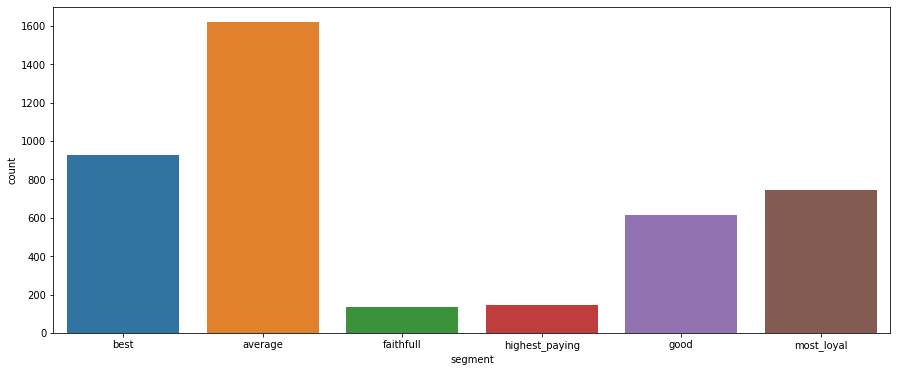

In [27]:
plt.figure(figsize=(15,6))
ax=sns.countplot(data=rfm_scores,
                 x='segment')
plt.show()

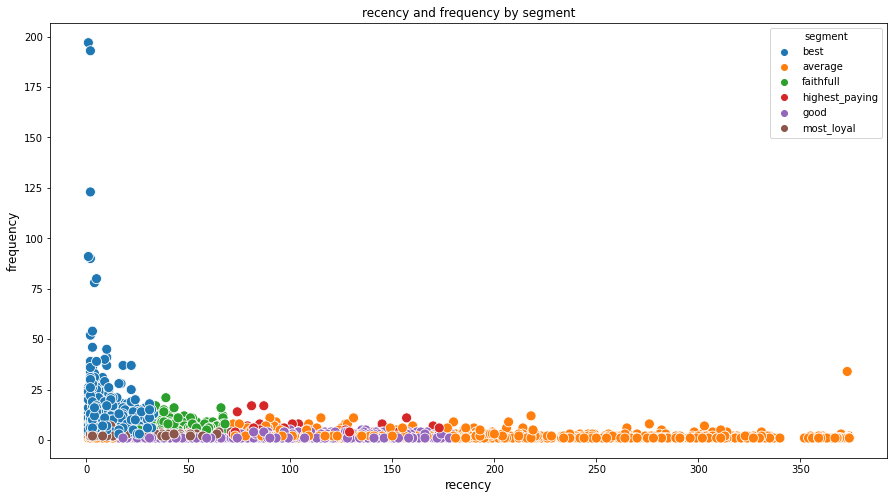

In [28]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=rfm_scores,x='recency',y='frequency',hue='segment',s=100)
plt.title('recency and frequency by segment')
plt.xlabel('recency',size=12)
plt.ylabel('frequency',size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [29]:
import plotly.express as px
fig=px.scatter_3d(rfm_scores,z='recency',y='frequency',x='monetry',color='segment',opacity=0.7)
fig.show()

# kmean -> this is one way to do this 

In [30]:
# rescaling the attributes
rfm_df=rfm[['recency','frequency','monetry']]
# instantiate
scaler=StandardScaler()
rfm_df_scaled=scaler.fit_transform(rfm_df)


In [31]:
rfm_df_scaled


array([[-0.9008155 ,  0.42494771,  1.03599609],
       [ 1.56202716, -0.14468401, -0.42631459],
       [-0.74063062, -0.42949987, -0.01410962],
       ...,
       [-0.85075773, -0.28709194, -0.41591593],
       [-0.89080395,  1.70661906,  0.46334432],
       [-0.50035328, -0.14468401, -0.03151932]])

In [32]:
kmeans=KMeans(n_clusters=6,max_iter=100)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=100, n_clusters=6)

In [33]:
kmeans.labels_

array([5, 0, 1, ..., 1, 5, 1], dtype=int32)

In [34]:
rfm_kmeans=rfm.copy()
# assign the value
rfm_kmeans['cluster_id']=(kmeans.labels_).astype(str)
rfm_kmeans.head()

,CustomerID,recency,frequency,monetry,cluster_id
0,12347,3,7,3314.73,5
1,12348,249,3,90.20,0
2,12349,19,1,999.15,1
3,12350,311,1,294.40,0
4,12352,37,7,1130.94,1


# ML classification -> second way

In [41]:
rfm_scores.head()

,CustomerID,recency,frequency,monetry,recency_score,frequency_score,monetry_score,RFM_score,segment
0,12347,3,7,3314.73,5,5,5,555,best
1,12348,249,3,90.20,1,3,1,131,average
2,12349,19,1,999.15,4,1,4,414,average
3,12350,311,1,294.40,1,1,2,112,average
4,12352,37,7,1130.94,3,5,4,354,faithfull


In [37]:
x=rfm_scores.drop(['CustomerID','segment'],axis=1)
y=rfm_scores['segment']

In [38]:
x_train ,x_test,y_train,y_test= train_test_split(x,y,test_size=.20,random_state=21)

In [39]:
print('training dataset ',x_train.shape)
print('testing dataset',x_test.shape)

training dataset  (3353, 7)
testing dataset (839, 7)


# logistic regression using hyperparameter tunning 

In [43]:
# define the parameter
parameters= {'max_iter':[1000,1500,2000]}
lr_classifier= LogisticRegression()
lr_classifier_rs= RandomizedSearchCV(estimator=lr_classifier,param_distributions=parameters,cv=5,random_state=21,verbose=1)

In [44]:
lr_classifier_rs.fit(x_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'max_iter': [1000, 1500, 2000]},
                   random_state=21, verbose=1)

In [45]:
# get best parameteres 
def get_best_parameters_result(model):
  print('Best estimator ', model.best_estimator_)
  print('Best set of parameter', model.best_params_)
  print('Best score',model.best_score_)

In [46]:
get_best_parameters_result(lr_classifier_rs)

Best estimator  LogisticRegression(max_iter=2000)
Best set of parameter {'max_iter': 2000}
Best score 0.8106301577062526


In [48]:
y_pred_lr=lr_classifier_rs.predict(x_test)

In [49]:
lr_accuracy=accuracy_score(y_true=y_test,y_pred=y_pred_lr)
print('Accuracy using logistic regression ',lr_accuracy)

Accuracy using logistic regression  0.8259833134684148


In [50]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,labels):
    fig, ax = plt.subplots(figsize=(6,4))
    im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax = ax)
    
    ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=labels, yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label')
    
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()

In [51]:
cm = confusion_matrix(y_test.values,y_pred_lr)
cm

array([[284,   0,   2,  30,   2,   8],
       [  0, 186,   1,   0,   0,   7],
       [  0,  10,  15,   0,   1,   3],
       [ 47,   0,   0,  70,   2,   8],
       [  1,   5,   0,   0,  22,   0],
       [  1,   3,   1,  11,   3, 116]])

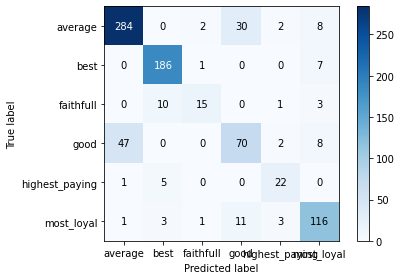

In [52]:
plot_confusion_matrix(cm, np.unique(y_pred_lr))

# svm with hyperparameter tuning and cross validation

In [54]:
parameters = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C':[1.0, 2.0]
}

svm_rs = RandomizedSearchCV(estimator = SVC(), param_distributions=parameters, cv = 5, random_state = 42, verbose = 1)

In [56]:
svm_rs.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [1.0, 2.0],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=42, verbose=1)

In [57]:
get_best_parameters_result(svm_rs)

Best estimator  SVC(C=2.0)
Best set of parameter {'kernel': 'rbf', 'C': 2.0}
Best score 0.69699179215695


In [58]:
y_pred_svm = svm_rs.predict(x_test)

In [59]:
svm_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_svm)
print("Accuracy using Kernel SVM : ", svm_accuracy)

Accuracy using Kernel SVM :  0.6901072705601907


In [60]:
cm = confusion_matrix(y_test.values, y_pred_svm)
cm

array([[285,   4,   0,   0,   5,  32],
       [  0, 180,   0,   0,   0,  14],
       [  0,  19,   0,   0,   0,  10],
       [107,   1,   0,   0,   0,  19],
       [  0,   9,   0,   0,  19,   0],
       [ 28,  12,   0,   0,   0,  95]])

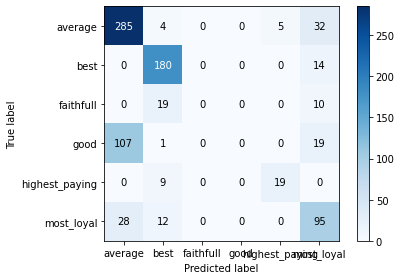

In [61]:
# cm = confusion_matrix(y_test.values,y_pred_lr)
plot_confusion_matrix(cm, np.unique(y_pred_lr))

# Decision tree with hyperparameter tunning and cross validation 

In [62]:
parameters = {'max_depth': np.arange(2, 20, 2)}

dt_classifier = DecisionTreeClassifier()
dt_classifier_rs = RandomizedSearchCV(dt_classifier, param_distributions = parameters, random_state = 42, cv = 5, verbose = 1)
dt_classifier_rs.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
                   random_state=42, verbose=1)

In [63]:
y_pred_dt = dt_classifier_rs.predict(x_test)

In [64]:
dt_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_dt)
print("Accuracy using Decision tree : ", dt_accuracy)

Accuracy using Decision tree :  0.9976162097735399


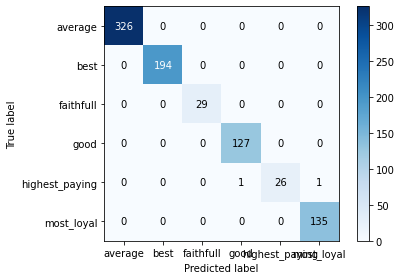

In [65]:
cm = confusion_matrix(y_test.values,y_pred_dt)
plot_confusion_matrix(cm, np.unique(y_pred_dt))

# Random forest 


In [66]:
parameters = {
    'n_estimators':[110,130,140,150,160,180,200], 
    'max_depth': np.arange(2, 17, 2)
}
rf_classifier = RandomForestClassifier()
rf_classifier_rs = RandomizedSearchCV(rf_classifier, param_distributions=parameters,random_state = 42, verbose = 1, cv = 5)
rf_classifier_rs.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
                                        'n_estimators': [110, 130, 140, 150,
                                                         160, 180, 200]},
                   random_state=42, verbose=1)

In [67]:
y_pred = rf_classifier_rs.predict(x_test)

In [68]:
rf_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy using Random forest : ", rf_accuracy)

Accuracy using Random forest :  0.99880810488677


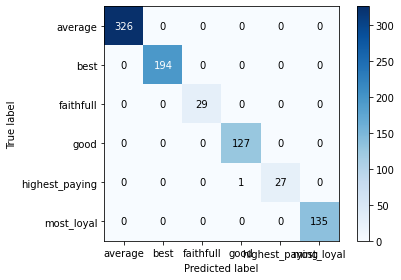

In [69]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred))

In [70]:
model_results = {
    'LR': lr_accuracy,
    'SVM': svm_accuracy,
    'DT': dt_accuracy,
    'RF': rf_accuracy
}

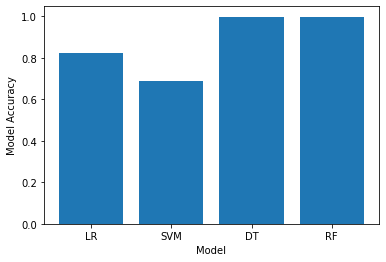

In [71]:
plt.bar(range(len(model_results)), model_results.values(), align='center')
plt.xticks(range(len(model_results)), list(model_results.keys()))
plt.ylabel("Model Accuracy")
plt.xlabel("Model")
plt.show()

https://www.barilliance.com/rfm-analysis/#tab-con-7